In [5]:
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import math
from os import path
from keras.models import Sequential
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from numpy import hstack
import tensorflow as tf
import numpy as np
from collections import Counter
%matplotlib inline

In [6]:
DATA_DIR = "../../data"

# Load Data

In [7]:
chen_train = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_train_data.csv"), index_col=0)
chen_train.head()

,Antibody_ID,heavy,light,Y
2073,6aod,EVQLVQSGAEVKKPGASVKVSCKASGYTFTGYYMHWVRQAPGQGLE...,DIVMTKSPSSLSASVGDRVTITCRASQGIRNDLGWYQQKPGKAPKR...,0
1517,4yny,EVQLVESGGGLVQPGRSLKLSCAASGFTFSNYGMAWVRQTPTKGLE...,EFVLTQPNSVSTNLGSTVKLSCKRSTGNIGSNYVNWYQQHEGRSPT...,1
2025,5xcv,EVQLVESGGGLVQPGRSLKLSCAASGFTFSNYGMAWVRQTPTKGLE...,QFVLTQPNSVSTNLGSTVKLSCKRSTGNIGSNYVNWYQQHEGRSPT...,1
2070,6and,EVQLVESGGGLVQPGGSLRLSCAASGYEFSRSWMNWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRSSQSIVHSVGNTFLEWYQQKPG...,1
666,2xqy,QVQLQQPGAELVKPGASVKMSCKASGYSFTSYWMNWVKQRPGRGLE...,DIVLTQSPASLALSLGQRATISCRASKSVSTSGYSYMYWYQQKPGQ...,0


In [8]:
chen_valid = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_valid_data.csv"), index_col=0)
chen_test = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_test_data.csv"), index_col=0)
chen_valid = pd.concat([chen_valid, chen_test])
chen_valid.head()

,Antibody_ID,heavy,light,Y
2169,6ct7,EVQLVESGGGLVEPGGSLRLSCAVSGFDFEKAWMSWVRQAPGQGLQ...,SYELTQPPSVSVSPGQTARITCSGEALPMQFAHWYQQRPGKAPVIV...,0
1342,4nzu,AVSLVESGGGTVEPGSTLRLSCAASGFTFGSYAFHWVRQAPGDGLE...,DIEMTQSPSSLSASTGDKVTITCQASQDIAKFLDWYQQRPGKTPKL...,0
1728,5i8c,QEVLVQSGAEVKKPGASVKVSCRAFGYTFTGNALHWVRQAPGQGLE...,DIQLTQSPSFLSASVGDKVTITCRASQGVRNELAWYQQKPGKAPNL...,1
1729,5i8e,QEVLVQSGAEVKKPGASVKVSCRAFGYTFTGNALHWVRQAPGQGLE...,IQLTQSPSFLSASVGDKVTITCRASQGVRNELAWYQQKPGKAPNLL...,0
2114,6bb4,QVQLQQSDAELVKPGASVKISCKASGYTFTDRTIHWVKQRPEQGLE...,DVQMIQSPSSLSASLGDIVTMTCQASQDTSINLNWFQQKPGKAPKL...,0


In [9]:
x_chen = pd.read_csv(path.join(DATA_DIR, "chen/integer_encoding/chen_integer_encoded.csv"), index_col=0)
x_chen_train = x_chen.loc[chen_train.index]
x_chen_test = x_chen.loc[chen_valid.index]
x_chen_train.head()

,Ab_ID,0,1,2,3,4,5,6,7,8,...,271,272,273,274,275,276,277,278,279,280
2073,6aod,4,18,14,10,18,14,16,6,1,...,0,0,0,0,0,0,0,0,0,0
1517,4yny,4,18,14,10,18,4,16,6,6,...,0,0,0,0,0,0,0,0,0,0
2025,5xcv,4,18,14,10,18,4,16,6,6,...,0,0,0,0,0,0,0,0,0,0
2070,6and,4,18,14,10,18,4,16,6,6,...,0,0,0,0,0,0,0,0,0,0
666,2xqy,14,18,14,10,14,14,13,6,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X_train = x_chen_train.drop("Ab_ID", axis=1).to_numpy()
X_test = x_chen_test.drop("Ab_ID", axis=1).to_numpy()

In [11]:
y_train = chen_train["Y"].to_numpy()
y_test = chen_valid["Y"].to_numpy()

In [14]:
max_length = len(X_train[0])
print(max_length)

281


In [13]:
def binarize(prediction, thresh=0.5):
    res = []
    for pred in prediction:
        if pred < thresh:
            res.append(0)
        else:
            res.append(1)
    return res

# Models

### Model 1

In [11]:
model = Sequential()
model.add(LSTM(
    50, activation='sigmoid', return_sequences=True, input_shape=(max_length, 1), kernel_regularizer="l2",
    recurrent_regularizer="l2", bias_regularizer="l2"
))
model.add(LSTM(50, activation='sigmoid', kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss="binary_crossentropy")

2021-12-20 09:58:35.298624: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 281, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.fit(X_train, y_train, epochs=200, verbose=1, batch_size=128)

Epoch 1/200
11/11 [==============================] - 6s 317ms/step - loss: 3.2986
Epoch 2/200
11/11 [==============================] - 3s 317ms/step - loss: 2.8671
Epoch 3/200
11/11 [==============================] - 4s 319ms/step - loss: 2.5602
Epoch 4/200
11/11 [==============================] - 3s 308ms/step - loss: 2.3076
Epoch 5/200
11/11 [==============================] - 3s 316ms/step - loss: 2.1045
Epoch 6/200
11/11 [==============================] - 3s 316ms/step - loss: 1.9381
Epoch 7/200
11/11 [==============================] - 4s 320ms/step - loss: 1.8027
Epoch 8/200
11/11 [==============================] - 4s 317ms/step - loss: 1.6919
Epoch 9/200
11/11 [==============================] - 3s 318ms/step - loss: 1.6005
Epoch 10/200
11/11 [==============================] - 3s 311ms/step - loss: 1.5245
Epoch 11/200
11/11 [==============================] - 3s 313ms/step - loss: 1.4613
Epoch 12/200
11/11 [==============================] - 3s 311ms/step - loss: 1.4079
Epoch 13/200


In [80]:
model.evaluate(X_test, y_test, batch_size=1)

239/239 [==============================] - 7s 29ms/step - loss: 0.5075


0.5074639916419983

### Model 2

In [17]:
model = Sequential()
model.add(LSTM(
    50, activation='relu', return_sequences=True, input_shape=(max_length, 1), kernel_regularizer="l2",
    recurrent_regularizer="l2", bias_regularizer="l2"
))
model.add(LSTM(50, activation='relu', kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss="binary_crossentropy")

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 281, 50)           10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train, y_train, epochs=200, verbose=1, batch_size=64)

Epoch 1/200
21/21 [==============================] - 7s 244ms/step - loss: 612956672.0000
Epoch 2/200
21/21 [==============================] - 5s 236ms/step - loss: 3.4039
Epoch 3/200
21/21 [==============================] - 5s 238ms/step - loss: 3.3552
Epoch 4/200
21/21 [==============================] - 5s 245ms/step - loss: 3.3202
Epoch 5/200
21/21 [==============================] - 5s 237ms/step - loss: 3.2948
Epoch 6/200
21/21 [==============================] - 5s 241ms/step - loss: 3.2754
Epoch 7/200
21/21 [==============================] - 5s 247ms/step - loss: 3.2599
Epoch 8/200
21/21 [==============================] - 5s 236ms/step - loss: 3.2471
Epoch 9/200
21/21 [==============================] - 5s 240ms/step - loss: 3.2353
Epoch 10/200
21/21 [==============================] - 5s 241ms/step - loss: 3.2236
Epoch 11/200
21/21 [==============================] - 5s 237ms/step - loss: 3.2103
Epoch 12/200
21/21 [==============================] - 5s 239ms/step - loss: 3.1900
Epoch

KeyboardInterrupt: 

In [20]:
model.evaluate(X_test, y_test, batch_size=1)

239/239 [==============================] - 7s 29ms/step - loss: 3.0515


3.0515201091766357

In [21]:
y_pred = model.predict(X_test)
y_pred

array([[0.20992106],
       [0.20791924],
       [0.20984468],
       [0.21016249],
       [0.21216676],
       [0.21036375],
       [0.21095589],
       [0.21002048],
       [0.20772734],
       [0.20795539],
       [0.21061528],
       [0.21096697],
       [0.19717345],
       [0.19761881],
       [0.21084765],
       [0.211494  ],
       [0.21031821],
       [0.21067479],
       [0.20984936],
       [0.21006978],
       [0.20541656],
       [0.20973724],
       [0.20973724],
       [0.21127683],
       [0.21076229],
       [0.21076572],
       [0.20804015],
       [0.18784446],
       [0.21132302],
       [0.21070066],
       [0.2109569 ],
       [0.21123934],
       [0.20929185],
       [0.21117595],
       [0.21117586],
       [0.21108863],
       [0.21083713],
       [0.21036819],
       [0.2104238 ],
       [0.21092072],
       [0.21110901],
       [0.21186692],
       [0.20862168],
       [0.21096504],
       [0.20865539],
       [0.20658135],
       [0.1993657 ],
       [0.210

### Model 3

In [50]:
model = Sequential()
model.add(LSTM(200, activation="relu", input_shape=(max_length, 1), return_sequences=True))  
model.add(Dropout(0.2))  
model.add(LSTM(200, activation="relu", return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss="binary_crossentropy")

In [52]:
model.fit(X_train, y_train, epochs=200, verbose=1, batch_size=128)

Epoch 1/200
11/11 [==============================] - 33s 3s/step - loss: 9.4642
Epoch 2/200
11/11 [==============================] - 33s 3s/step - loss: 11.9568
Epoch 3/200
11/11 [==============================] - 33s 3s/step - loss: 12.0353
Epoch 4/200
11/11 [==============================] - 33s 3s/step - loss: 12.0467
Epoch 5/200
11/11 [==============================] - 33s 3s/step - loss: 12.0467
Epoch 6/200
11/11 [==============================] - 32s 3s/step - loss: 12.0353
Epoch 7/200
11/11 [==============================] - 33s 3s/step - loss: 12.0353
Epoch 8/200
11/11 [==============================] - 33s 3s/step - loss: 12.0354
Epoch 9/200
11/11 [==============================] - 33s 3s/step - loss: 12.0467
Epoch 10/200
11/11 [==============================] - 33s 3s/step - loss: 12.0467
Epoch 11/200
11/11 [==============================] - 32s 3s/step - loss: 12.0353
Epoch 12/200
11/11 [==============================] - 33s 3s/step - loss: 12.0353
Epoch 13/200
11/11 [======

KeyboardInterrupt: 

### Model 4

In [55]:
model = Sequential()
model.add(LSTM(200, activation="relu", input_shape=(max_length, 1), return_sequences=True,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))  
model.add(Dropout(0.1))  
model.add(LSTM(200, activation="relu", return_sequences=False,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss="binary_crossentropy")

In [56]:
model.fit(X_train, y_train, epochs=100, verbose=1, batch_size=128)

Epoch 1/100
11/11 [==============================] - 33s 3s/step - loss: 11.3796
Epoch 2/100
11/11 [==============================] - 31s 3s/step - loss: 8.6393
Epoch 3/100
11/11 [==============================] - 31s 3s/step - loss: 7.1998
Epoch 4/100
11/11 [==============================] - 30s 3s/step - loss: 6.2318
Epoch 5/100
11/11 [==============================] - 31s 3s/step - loss: 5.5878
Epoch 6/100
11/11 [==============================] - 31s 3s/step - loss: 5.1504
Epoch 7/100
11/11 [==============================] - 31s 3s/step - loss: 4.8413
Epoch 8/100
11/11 [==============================] - 31s 3s/step - loss: 4.6171
Epoch 9/100
11/11 [==============================] - 31s 3s/step - loss: 4.4382
Epoch 10/100
11/11 [==============================] - 31s 3s/step - loss: 4.2898
Epoch 11/100
11/11 [==============================] - 31s 3s/step - loss: 4.1615
Epoch 12/100
11/11 [==============================] - 32s 3s/step - loss: 4.0487
Epoch 13/100
11/11 [================

## Over-sampling

In [22]:
sampler = RandomOverSampler(random_state=42)

X_train_os, y_train_os = sampler.fit_resample(X_train, y_train) 
print('Resampled dataset shape %s' % Counter(y_train_os)) 

Resampled dataset shape Counter({0: 1057, 1: 1057})


### Model 1 + OS

In [23]:
model = Sequential()
model.add(LSTM(
    50, activation='sigmoid', return_sequences=True, input_shape=(max_length, 1), kernel_regularizer="l2",
    recurrent_regularizer="l2", bias_regularizer="l2"
))
model.add(LSTM(50, activation='sigmoid', kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss="binary_crossentropy")

In [25]:
model.fit(X_train_os, y_train_os, epochs=100, verbose=1, batch_size=128)

Epoch 1/100
17/17 [==============================] - 6s 329ms/step - loss: 3.1067
Epoch 2/100
17/17 [==============================] - 6s 337ms/step - loss: 2.6443
Epoch 3/100
17/17 [==============================] - 6s 328ms/step - loss: 2.3104
Epoch 4/100
17/17 [==============================] - 5s 323ms/step - loss: 2.0626
Epoch 5/100
17/17 [==============================] - 6s 338ms/step - loss: 1.8793
Epoch 6/100
17/17 [==============================] - 6s 329ms/step - loss: 1.7428
Epoch 7/100
17/17 [==============================] - 6s 325ms/step - loss: 1.6398
Epoch 8/100
17/17 [==============================] - 6s 326ms/step - loss: 1.5603
Epoch 9/100
17/17 [==============================] - 6s 347ms/step - loss: 1.4975
Epoch 10/100
17/17 [==============================] - 6s 327ms/step - loss: 1.4471
Epoch 11/100
17/17 [==============================] - 6s 327ms/step - loss: 1.4052
Epoch 12/100
17/17 [==============================] - 6s 365ms/step - loss: 1.3683
Epoch 13/100


In [26]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred

8/8 [==============================] - 1s 52ms/step - loss: 0.7067


array([[0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.50901216],
       [0.509

### Model 4 + OS

In [30]:
model = Sequential()
model.add(LSTM(200, activation="relu", input_shape=(max_length, 1), return_sequences=True,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))  
model.add(Dropout(0.1))  
model.add(LSTM(200, activation="relu", return_sequences=False,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss="binary_crossentropy")

In [31]:
model.fit(X_train_os, y_train_os, epochs=100, verbose=1, batch_size=128)

Epoch 1/100
17/17 [==============================] - 134s 3s/step - loss: 16.8643
Epoch 2/100
17/17 [==============================] - 49s 3s/step - loss: 13.8616
Epoch 3/100
17/17 [==============================] - 49s 3s/step - loss: 12.3750
Epoch 4/100
17/17 [==============================] - 49s 3s/step - loss: 11.6591
Epoch 5/100
17/17 [==============================] - 49s 3s/step - loss: 11.2934
Epoch 6/100
17/17 [==============================] - 49s 3s/step - loss: 11.0774
Epoch 7/100
17/17 [==============================] - 49s 3s/step - loss: 10.9232
Epoch 8/100
17/17 [==============================] - 49s 3s/step - loss: 10.7946
Epoch 9/100
17/17 [==============================] - 49s 3s/step - loss: 10.6777
Epoch 10/100
17/17 [==============================] - 49s 3s/step - loss: 10.5672
Epoch 11/100
17/17 [==============================] - 49s 3s/step - loss: 10.4611
Epoch 12/100
17/17 [==============================] - 49s 3s/step - loss: 10.3585
Epoch 13/100
17/17 [====

KeyboardInterrupt: 

In [32]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred

8/8 [==============================] - 3s 346ms/step - loss: 4.6476


array([[-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0.00703877],
       [-0

So it looks like over-sampling didn't help :(

### Model 5

In [35]:
model = Sequential()
model.add(LSTM(128, activation="relu", input_shape=(max_length, 1), return_sequences=True,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))  
model.add(LSTM(128, activation="relu", return_sequences=False,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss="binary_crossentropy")

In [36]:
model.fit(X_train, y_train, epochs=100, verbose=1, batch_size=128)

Epoch 1/100
11/11 [==============================] - 17s 1s/step - loss: 7.1326
Epoch 2/100
11/11 [==============================] - 15s 1s/step - loss: 5.6832
Epoch 3/100
11/11 [==============================] - 15s 1s/step - loss: 4.7034
Epoch 4/100
11/11 [==============================] - 15s 1s/step - loss: 4.0404
Epoch 5/100
11/11 [==============================] - 15s 1s/step - loss: 3.5787
Epoch 6/100
11/11 [==============================] - 15s 1s/step - loss: 3.2596
Epoch 7/100
11/11 [==============================] - 15s 1s/step - loss: 3.0345
Epoch 8/100
11/11 [==============================] - 16s 1s/step - loss: 2.8718
Epoch 9/100
11/11 [==============================] - 15s 1s/step - loss: 2.7510
Epoch 10/100
11/11 [==============================] - 15s 1s/step - loss: 2.6568
Epoch 11/100
11/11 [==============================] - 15s 1s/step - loss: 2.5803
Epoch 12/100
11/11 [==============================] - 15s 1s/step - loss: 2.5151
Epoch 13/100
11/11 [=================

In [37]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred

8/8 [==============================] - 2s 207ms/step - loss: 0.6243


array([[0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.21855006],
       [0.218

### Model 5 + OS

In [40]:
model = Sequential()
model.add(LSTM(128, activation="relu", input_shape=(max_length, 1), return_sequences=True,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))  
model.add(LSTM(128, activation="relu", return_sequences=False,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss="binary_crossentropy")

In [41]:
model.fit(X_train_os, y_train_os, epochs=100, verbose=1, batch_size=128)

Epoch 1/100
17/17 [==============================] - 25s 1s/step - loss: 6.7897
Epoch 2/100
17/17 [==============================] - 23s 1s/step - loss: 5.0410
Epoch 3/100
17/17 [==============================] - 23s 1s/step - loss: 4.0339
Epoch 4/100
17/17 [==============================] - 23s 1s/step - loss: 3.4642
Epoch 5/100
17/17 [==============================] - 23s 1s/step - loss: 3.1340
Epoch 6/100
17/17 [==============================] - 24s 1s/step - loss: 2.9322
Epoch 7/100
17/17 [==============================] - 24s 1s/step - loss: 2.7932
Epoch 8/100
17/17 [==============================] - 24s 1s/step - loss: 2.6893
Epoch 9/100
17/17 [==============================] - 23s 1s/step - loss: 2.6033
Epoch 10/100
17/17 [==============================] - 23s 1s/step - loss: 2.5267
Epoch 11/100
17/17 [==============================] - 23s 1s/step - loss: 2.4558
Epoch 12/100
17/17 [==============================] - 23s 1s/step - loss: 2.3885
Epoch 13/100
17/17 [=================

In [42]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred

8/8 [==============================] - 2s 182ms/step - loss: 0.6943


array([[0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],
       [0.4949502],


### Model 4.2

In [48]:
model = Sequential()
model.add(LSTM(200, activation="relu", input_shape=(max_length, 1), return_sequences=True,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))  
model.add(Dropout(0.1))  
model.add(LSTM(200, activation="relu", return_sequences=False,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss="binary_crossentropy")

In [49]:
model.fit(X_train, y_train, epochs=100, verbose=1, batch_size=128)

Epoch 1/100
11/11 [==============================] - 33s 3s/step - loss: 10.5423
Epoch 2/100
11/11 [==============================] - 30s 3s/step - loss: 7.9961
Epoch 3/100
11/11 [==============================] - 31s 3s/step - loss: 6.4224
Epoch 4/100
11/11 [==============================] - 31s 3s/step - loss: 5.4357
Epoch 5/100
11/11 [==============================] - 30s 3s/step - loss: 4.8218
Epoch 6/100
11/11 [==============================] - 30s 3s/step - loss: 4.4360
Epoch 7/100
11/11 [==============================] - 31s 3s/step - loss: 4.1834
Epoch 8/100
11/11 [==============================] - 31s 3s/step - loss: 4.0097
Epoch 9/100
11/11 [==============================] - 31s 3s/step - loss: 3.8825
Epoch 10/100
11/11 [==============================] - 31s 3s/step - loss: 3.7773
Epoch 11/100
11/11 [==============================] - 31s 3s/step - loss: 3.6868
Epoch 12/100
11/11 [==============================] - 31s 3s/step - loss: 3.6036
Epoch 13/100
11/11 [================

In [50]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred

8/8 [==============================] - 3s 323ms/step - loss: 0.6891


array([[0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.20466083],
       [0.204

## Early Stopping

### Model 5 + ES

In [69]:
model = Sequential()
model.add(LSTM(128, activation="relu", input_shape=(max_length, 1), return_sequences=True,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))  
model.add(LSTM(128, activation="relu", return_sequences=False,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss="binary_crossentropy")

In [70]:
es = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, verbose=1, batch_size=128, validation_split=0.3, callbacks=[es])


Epoch 1/100
8/8 [==============================] - 14s 2s/step - loss: 7.3776 - val_loss: 6.6472
Epoch 2/100
8/8 [==============================] - 12s 1s/step - loss: 6.2244 - val_loss: 5.6264
Epoch 3/100
8/8 [==============================] - 12s 2s/step - loss: 5.3372 - val_loss: 4.9049
Epoch 4/100
8/8 [==============================] - 12s 2s/step - loss: 4.6828 - val_loss: 4.3465
Epoch 5/100
8/8 [==============================] - 12s 1s/step - loss: 4.1796 - val_loss: 3.9246
Epoch 6/100
8/8 [==============================] - 14s 2s/step - loss: 3.7991 - val_loss: 3.5998
Epoch 7/100
8/8 [==============================] - 12s 2s/step - loss: 3.5061 - val_loss: 3.3495
Epoch 8/100
8/8 [==============================] - 13s 2s/step - loss: 3.2825 - val_loss: 3.1576
Epoch 9/100
8/8 [==============================] - 14s 2s/step - loss: 3.1080 - val_loss: 3.0124
Epoch 10/100
8/8 [==============================] - 15s 2s/step - loss: 2.9726 - val_loss: 2.8928
Epoch 11/100
8/8 [===========

In [71]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred

8/8 [==============================] - 2s 190ms/step - loss: 1.6144


array([[0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.21184444],
       [0.21184433],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.21184525],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.2118442 ],
       [0.21184427],
       [0.211

## Model 5 + ES + OS

In [72]:
model = Sequential()
model.add(LSTM(128, activation="relu", input_shape=(max_length, 1), return_sequences=True,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))  
model.add(LSTM(128, activation="relu", return_sequences=False,
              kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss="binary_crossentropy")

In [73]:
es = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
model.fit(X_train_os, y_train_os, epochs=100, verbose=1, batch_size=128, validation_split=0.3, callbacks=[es])

Epoch 1/100
12/12 [==============================] - 23s 2s/step - loss: 7.0680 - val_loss: 6.5489
Epoch 2/100
12/12 [==============================] - 19s 2s/step - loss: 5.5926 - val_loss: 5.7582
Epoch 3/100
12/12 [==============================] - 19s 2s/step - loss: 4.6087 - val_loss: 4.7859
Epoch 4/100
12/12 [==============================] - 19s 2s/step - loss: 3.9531 - val_loss: 4.3299
Epoch 5/100
12/12 [==============================] - 18s 2s/step - loss: 3.5155 - val_loss: 3.9886
Epoch 6/100
12/12 [==============================] - 18s 2s/step - loss: 3.2196 - val_loss: 3.7645
Epoch 7/100
12/12 [==============================] - 19s 2s/step - loss: 3.0155 - val_loss: 3.5850
Epoch 8/100
12/12 [==============================] - 19s 2s/step - loss: 2.8688 - val_loss: 3.4322
Epoch 9/100
12/12 [==============================] - 19s 2s/step - loss: 2.7595 - val_loss: 3.3866
Epoch 10/100
12/12 [==============================] - 19s 2s/step - loss: 2.6731 - val_loss: 3.2940
Epoch 11/

In [74]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred

8/8 [==============================] - 2s 196ms/step - loss: 0.6244


array([[0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.2980025 ],
       [0.298

In [3]:
def are_same(arr):
    return np.all(arr == arr[0])

In [31]:
for i in range(10, 20):
    model = Sequential()
    model.add(LSTM(128, activation="relu", input_shape=(max_length, 1), return_sequences=True,
                  kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))  
    model.add(LSTM(128, activation="relu", return_sequences=False,
                  kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer='adam', loss="binary_crossentropy")

    es = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=300, verbose=1, batch_size=128, validation_data=(X_test, y_test), callbacks=[es])

    try:
        model.save(path.join(DATA_DIR, f"models/LSTM5_{i}"))

        y_pred = model.predict(X_test)
        if not are_same(y_pred):
            print(i)
    except:
        pass
    

Epoch 1/300
11/11 [==============================] - 13s 1s/step - loss: 7.1348 - val_loss: 6.2245
Epoch 2/300
11/11 [==============================] - 11s 986ms/step - loss: 5.6714 - val_loss: 5.0717
Epoch 3/300
11/11 [==============================] - 11s 989ms/step - loss: 4.7085 - val_loss: 4.2816
Epoch 4/300
11/11 [==============================] - 11s 980ms/step - loss: 4.0416 - val_loss: 3.7441
Epoch 5/300
11/11 [==============================] - 11s 985ms/step - loss: 3.5809 - val_loss: 3.3725
Epoch 6/300
11/11 [==============================] - 11s 990ms/step - loss: 3.2613 - val_loss: 3.1141
Epoch 7/300
11/11 [==============================] - 11s 989ms/step - loss: 3.0356 - val_loss: 2.9270
Epoch 8/300
11/11 [==============================] - 11s 991ms/step - loss: 2.8737 - val_loss: 2.7907
Epoch 9/300
11/11 [==============================] - 11s 983ms/step - loss: 2.7517 - val_loss: 2.6865
Epoch 10/300
11/11 [==============================] - 11s 978ms/step - loss: 2.6576 -

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_10/assets


10
Epoch 1/300
11/11 [==============================] - 41s 1s/step - loss: nan - val_loss: nan
Epoch 2/300
11/11 [==============================] - 11s 985ms/step - loss: nan - val_loss: nan
Epoch 3/300
11/11 [==============================] - 11s 989ms/step - loss: nan - val_loss: nan
Epoch 4/300
11/11 [==============================] - 11s 982ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_11/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_11/assets


11
Epoch 1/300
11/11 [==============================] - 13s 1s/step - loss: 7.1409 - val_loss: 6.2313
Epoch 2/300
11/11 [==============================] - 11s 987ms/step - loss: 5.6878 - val_loss: 5.0650
Epoch 3/300
11/11 [==============================] - 11s 986ms/step - loss: 4.7129 - val_loss: 4.2874
Epoch 4/300
11/11 [==============================] - 11s 983ms/step - loss: 4.0495 - val_loss: 3.7497
Epoch 5/300
11/11 [==============================] - 11s 988ms/step - loss: 3.5860 - val_loss: 3.3772
Epoch 6/300
11/11 [==============================] - 11s 985ms/step - loss: 3.2656 - val_loss: 3.1164
Epoch 7/300
11/11 [==============================] - 11s 986ms/step - loss: 3.0392 - val_loss: 2.9300
Epoch 8/300
11/11 [==============================] - 11s 985ms/step - loss: 2.8757 - val_loss: 2.7924
Epoch 9/300
11/11 [==============================] - 11s 976ms/step - loss: 2.7541 - val_loss: 2.6874
Epoch 10/300
11/11 [==============================] - 11s 987ms/step - loss: 2.658

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_12/assets


12
Epoch 1/300
11/11 [==============================] - 13s 1s/step - loss: 7.1278 - val_loss: 6.2113
Epoch 2/300
11/11 [==============================] - 11s 980ms/step - loss: 5.6628 - val_loss: 5.0633
Epoch 3/300
11/11 [==============================] - 11s 977ms/step - loss: 4.7065 - val_loss: 4.2758
Epoch 4/300
11/11 [==============================] - 11s 979ms/step - loss: 4.0359 - val_loss: 3.7385
Epoch 5/300
11/11 [==============================] - 11s 975ms/step - loss: 3.5744 - val_loss: 3.3680
Epoch 6/300
11/11 [==============================] - 11s 981ms/step - loss: 3.2576 - val_loss: 3.1087
Epoch 7/300
11/11 [==============================] - 11s 982ms/step - loss: 3.0322 - val_loss: 2.9243
Epoch 8/300
11/11 [==============================] - 11s 981ms/step - loss: 2.8705 - val_loss: 2.7882
Epoch 9/300
11/11 [==============================] - 11s 981ms/step - loss: 2.7495 - val_loss: 2.6844
Epoch 10/300
11/11 [==============================] - 11s 987ms/step - loss: 2.656

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_13/assets


13
Epoch 1/300
11/11 [==============================] - 13s 1s/step - loss: nan - val_loss: nan
Epoch 2/300
11/11 [==============================] - 11s 972ms/step - loss: nan - val_loss: nan
Epoch 3/300
11/11 [==============================] - 11s 973ms/step - loss: nan - val_loss: nan
Epoch 4/300
11/11 [==============================] - 11s 970ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_14/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_14/assets


14
Epoch 1/300
11/11 [==============================] - 13s 1s/step - loss: nan - val_loss: nan
Epoch 2/300
11/11 [==============================] - 11s 972ms/step - loss: nan - val_loss: nan
Epoch 3/300
11/11 [==============================] - 11s 982ms/step - loss: nan - val_loss: nan
Epoch 4/300
11/11 [==============================] - 11s 977ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_15/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_15/assets


15
Epoch 1/300
11/11 [==============================] - 13s 1s/step - loss: nan - val_loss: nan
Epoch 2/300
11/11 [==============================] - 11s 981ms/step - loss: nan - val_loss: nan
Epoch 3/300
11/11 [==============================] - 11s 977ms/step - loss: nan - val_loss: nan
Epoch 4/300
11/11 [==============================] - 11s 975ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_16/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_16/assets


16
Epoch 1/300
11/11 [==============================] - 13s 1s/step - loss: nan - val_loss: nan
Epoch 2/300
11/11 [==============================] - 11s 981ms/step - loss: nan - val_loss: nan
Epoch 3/300
11/11 [==============================] - 11s 980ms/step - loss: nan - val_loss: nan
Epoch 4/300
11/11 [==============================] - 11s 979ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_17/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_17/assets


17
Epoch 1/300
11/11 [==============================] - 13s 1s/step - loss: 7.1157 - val_loss: 6.2049
Epoch 2/300
11/11 [==============================] - 11s 1s/step - loss: 5.6557 - val_loss: 5.0572
Epoch 3/300
11/11 [==============================] - 11s 1s/step - loss: 4.7057 - val_loss: 4.2720
Epoch 4/300
11/11 [==============================] - 11s 1s/step - loss: 4.0357 - val_loss: 3.7392
Epoch 5/300
11/11 [==============================] - 11s 1s/step - loss: 3.5768 - val_loss: 3.3690
Epoch 6/300
11/11 [==============================] - 11s 1s/step - loss: 3.2587 - val_loss: 3.1113
Epoch 7/300
11/11 [==============================] - 11s 1s/step - loss: 3.0348 - val_loss: 2.9258
Epoch 8/300
11/11 [==============================] - 11s 1s/step - loss: 2.8722 - val_loss: 2.7889
Epoch 9/300
11/11 [==============================] - 11s 1s/step - loss: 2.7506 - val_loss: 2.6852
Epoch 10/300
11/11 [==============================] - 11s 1s/step - loss: 2.6567 - val_loss: 2.6026
Epoch 

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_18/assets


18
Epoch 1/300
11/11 [==============================] - 13s 1s/step - loss: 7.1383 - val_loss: 6.2229
Epoch 2/300
11/11 [==============================] - 11s 978ms/step - loss: 5.6851 - val_loss: 5.0692
Epoch 3/300
11/11 [==============================] - 11s 978ms/step - loss: 4.7119 - val_loss: 4.2887
Epoch 4/300
11/11 [==============================] - 11s 974ms/step - loss: 4.0478 - val_loss: 3.7500
Epoch 5/300
11/11 [==============================] - 11s 992ms/step - loss: 3.5865 - val_loss: 3.3772
Epoch 6/300
11/11 [==============================] - 11s 976ms/step - loss: 3.2659 - val_loss: 3.1168
Epoch 7/300
11/11 [==============================] - 11s 983ms/step - loss: 3.0397 - val_loss: 2.9306
Epoch 8/300
11/11 [==============================] - 11s 987ms/step - loss: 2.8765 - val_loss: 2.7931
Epoch 9/300
11/11 [==============================] - 11s 987ms/step - loss: 2.7548 - val_loss: 2.6882
Epoch 10/300
11/11 [==============================] - 11s 988ms/step - loss: 2.660

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_19/assets


19


In [32]:
for i in range(21,41):
    model = Sequential()
    model.add(LSTM(128, activation="relu", input_shape=(max_length, 1), return_sequences=True,
                  kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))  
    model.add(LSTM(128, activation="relu", return_sequences=False,
                  kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer='adam', loss="binary_crossentropy")

    es = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
    model.fit(X_train_os, y_train_os, epochs=300, verbose=1, batch_size=128, validation_data=(X_test, y_test), callbacks=[es])

    try:
        model.save(path.join(DATA_DIR, f"models/LSTM5_{i}"))

        y_pred = model.predict(X_test)
        if not are_same(y_pred):
            print(i)
    except:
        pass

Epoch 1/300
17/17 [==============================] - 19s 994ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 973ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 17s 977ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 17s 979ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_21/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_21/assets


21
Epoch 1/300
17/17 [==============================] - 19s 996ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 974ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 16s 968ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 17s 980ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_22/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_22/assets


22
Epoch 1/300
17/17 [==============================] - 19s 998ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 973ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 17s 973ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 17s 978ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_23/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_23/assets


23
Epoch 1/300
17/17 [==============================] - 19s 999ms/step - loss: 6.7880 - val_loss: 5.6853
Epoch 2/300
17/17 [==============================] - 17s 978ms/step - loss: 5.0399 - val_loss: 4.3840
Epoch 3/300
17/17 [==============================] - 17s 975ms/step - loss: 4.0331 - val_loss: 3.6744
Epoch 4/300
17/17 [==============================] - 17s 975ms/step - loss: 3.4634 - val_loss: 3.2566
Epoch 5/300
17/17 [==============================] - 17s 975ms/step - loss: 3.1333 - val_loss: 3.0004
Epoch 6/300
17/17 [==============================] - 17s 975ms/step - loss: 2.9295 - val_loss: 2.8536
Epoch 7/300
17/17 [==============================] - 17s 977ms/step - loss: 2.7924 - val_loss: 2.7258
Epoch 8/300
17/17 [==============================] - 17s 977ms/step - loss: 2.6883 - val_loss: 2.6435
Epoch 9/300
17/17 [==============================] - 17s 972ms/step - loss: 2.6025 - val_loss: 2.5587
Epoch 10/300
17/17 [==============================] - 17s 975ms/step - loss: 2.

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_24/assets


24
Epoch 1/300
17/17 [==============================] - 19s 997ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 973ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 17s 977ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 17s 975ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_25/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_25/assets


25
Epoch 1/300
17/17 [==============================] - 19s 997ms/step - loss: 6.7885 - val_loss: 5.6981
Epoch 2/300
17/17 [==============================] - 17s 976ms/step - loss: 5.0416 - val_loss: 4.3961
Epoch 3/300
17/17 [==============================] - 17s 973ms/step - loss: 4.0353 - val_loss: 3.6736
Epoch 4/300
17/17 [==============================] - 17s 977ms/step - loss: 3.4659 - val_loss: 3.2474
Epoch 5/300
17/17 [==============================] - 17s 975ms/step - loss: 3.1348 - val_loss: 3.0000
Epoch 6/300
17/17 [==============================] - 17s 976ms/step - loss: 2.9312 - val_loss: 2.8443
Epoch 7/300
17/17 [==============================] - 17s 978ms/step - loss: 2.7932 - val_loss: 2.7317
Epoch 8/300
17/17 [==============================] - 16s 967ms/step - loss: 2.6893 - val_loss: 2.6414
Epoch 9/300
17/17 [==============================] - 17s 972ms/step - loss: 2.6033 - val_loss: 2.5646
Epoch 10/300
17/17 [==============================] - 17s 973ms/step - loss: 2.

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_26/assets


26
Epoch 1/300
17/17 [==============================] - 19s 992ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 976ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 16s 971ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 17s 974ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_27/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_27/assets


27
Epoch 1/300
17/17 [==============================] - 19s 996ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 980ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 17s 975ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 17s 973ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_28/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_28/assets


28
Epoch 1/300
17/17 [==============================] - 19s 999ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 979ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 17s 973ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 17s 975ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_29/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_29/assets


29
Epoch 1/300
17/17 [==============================] - 19s 984ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 975ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 17s 982ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 16s 967ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_30/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_30/assets


30
Epoch 1/300
17/17 [==============================] - 19s 997ms/step - loss: 6.7889 - val_loss: 5.6893
Epoch 2/300
17/17 [==============================] - 17s 977ms/step - loss: 5.0379 - val_loss: 4.3989
Epoch 3/300
17/17 [==============================] - 17s 975ms/step - loss: 4.0298 - val_loss: 3.6619
Epoch 4/300
17/17 [==============================] - 17s 974ms/step - loss: 3.4609 - val_loss: 3.2522
Epoch 5/300
17/17 [==============================] - 17s 974ms/step - loss: 3.1311 - val_loss: 3.0052
Epoch 6/300
17/17 [==============================] - 17s 973ms/step - loss: 2.9287 - val_loss: 2.8466
Epoch 7/300
17/17 [==============================] - 17s 974ms/step - loss: 2.7913 - val_loss: 2.7246
Epoch 8/300
17/17 [==============================] - 17s 978ms/step - loss: 2.6879 - val_loss: 2.6468
Epoch 9/300
17/17 [==============================] - 17s 972ms/step - loss: 2.6028 - val_loss: 2.5639
Epoch 10/300
17/17 [==============================] - 17s 971ms/step - loss: 2.

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_31/assets


31
Epoch 1/300
17/17 [==============================] - 19s 990ms/step - loss: 6.7981 - val_loss: 5.6993
Epoch 2/300
17/17 [==============================] - 17s 976ms/step - loss: 5.0464 - val_loss: 4.4000
Epoch 3/300
17/17 [==============================] - 17s 978ms/step - loss: 4.0371 - val_loss: 3.6730
Epoch 4/300
17/17 [==============================] - 17s 979ms/step - loss: 3.4652 - val_loss: 3.2564
Epoch 5/300
17/17 [==============================] - 17s 979ms/step - loss: 3.1340 - val_loss: 3.0024
Epoch 6/300
17/17 [==============================] - 17s 972ms/step - loss: 2.9302 - val_loss: 2.8435
Epoch 7/300
17/17 [==============================] - 17s 977ms/step - loss: 2.7919 - val_loss: 2.7271
Epoch 8/300
17/17 [==============================] - 17s 974ms/step - loss: 2.6889 - val_loss: 2.6331
Epoch 9/300
17/17 [==============================] - 17s 975ms/step - loss: 2.6029 - val_loss: 2.5469
Epoch 10/300
17/17 [==============================] - 17s 976ms/step - loss: 2.

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_32/assets


32
Epoch 1/300
17/17 [==============================] - 19s 991ms/step - loss: 6.7882 - val_loss: 5.6807
Epoch 2/300
17/17 [==============================] - 16s 972ms/step - loss: 5.0413 - val_loss: 4.3998
Epoch 3/300
17/17 [==============================] - 16s 970ms/step - loss: 4.0341 - val_loss: 3.6629
Epoch 4/300
17/17 [==============================] - 17s 978ms/step - loss: 3.4643 - val_loss: 3.2634
Epoch 5/300
17/17 [==============================] - 17s 975ms/step - loss: 3.1335 - val_loss: 3.0048
Epoch 6/300
17/17 [==============================] - 16s 965ms/step - loss: 2.9310 - val_loss: 2.8310
Epoch 7/300
17/17 [==============================] - 17s 978ms/step - loss: 2.7934 - val_loss: 2.7300
Epoch 8/300
17/17 [==============================] - 17s 972ms/step - loss: 2.6897 - val_loss: 2.6517
Epoch 9/300
17/17 [==============================] - 17s 976ms/step - loss: 2.6035 - val_loss: 2.5513
Epoch 10/300
17/17 [==============================] - 16s 965ms/step - loss: 2.

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_33/assets


33
Epoch 1/300
17/17 [==============================] - 19s 992ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 976ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 17s 973ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 16s 967ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_34/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_34/assets


34
Epoch 1/300
17/17 [==============================] - 19s 992ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 989ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 17s 972ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 17s 972ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_35/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_35/assets


35
Epoch 1/300
17/17 [==============================] - 19s 1s/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 978ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 16s 969ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 17s 976ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_36/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_36/assets


36
Epoch 1/300
17/17 [==============================] - 19s 987ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 974ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 17s 977ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 16s 969ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_37/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_37/assets


37
Epoch 1/300
17/17 [==============================] - 19s 996ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 974ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 17s 978ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 17s 974ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_38/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_38/assets


38
Epoch 1/300
17/17 [==============================] - 19s 996ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 972ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 17s 971ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 17s 971ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_39/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_39/assets


39
Epoch 1/300
17/17 [==============================] - 19s 992ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 17s 974ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 17s 972ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 17s 971ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_40/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_40/assets


40


Predictions of each model (models, which predict nan, were skipped)  
5 - all same  
7 - all same  
9 - one different: 114  
10 - 114  
12 - 114  
13 - 114  
18 - 114  
19 - 114  
24 - 114  
26 - 114, 196  
31 - 114  
32 - 114  
33 - 114  
Conclusion: Models produce the same results for all sequences except one, which is the longest.  

Attempt at solving this issue: trim long sequences.

# "Short" data

In [83]:
x_chen_short = pd.read_csv(path.join(DATA_DIR, "chen/integer_encoding/chen_integer_encoded_separate_short.csv"), index_col=0)
x_chen_train = x_chen_short.loc[chen_train.index]
x_chen_test = x_chen_short.loc[chen_valid.index]
x_chen_train.head()

,Ab_ID,0,1,2,3,4,5,6,7,8,...,225,226,227,228,229,230,231,232,233,234
2073,6aod,4,18,14,10,18,14,16,6,1,...,6,17,9,18,3,8,9,0,0,0
1517,4yny,4,18,14,10,18,4,16,6,6,...,6,6,6,17,9,10,17,18,10,0
2025,5xcv,4,18,14,10,18,4,16,6,6,...,6,6,6,17,9,10,17,18,10,0
2070,6and,4,18,14,10,18,4,16,6,6,...,20,17,5,6,14,6,17,9,18,4
666,2xqy,14,18,14,10,14,14,13,6,1,...,17,5,6,6,6,17,9,10,4,8


In [86]:
X_train = x_chen_train.drop("Ab_ID", axis=1).to_numpy()
X_test = x_chen_test.drop("Ab_ID", axis=1).to_numpy()

y_train = chen_train["Y"].to_numpy()
y_test = chen_valid["Y"].to_numpy()

In [76]:
max_length = len(X_train[0])
print(max_length)

235


In [ ]:
for i in range(40,50):
    model = Sequential()
    model.add(LSTM(128, activation="relu", input_shape=(max_length, 1), return_sequences=True,
                  kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))  
    model.add(LSTM(128, activation="relu", return_sequences=False,
                  kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer='adam', loss="binary_crossentropy")

    es = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=300, verbose=1, batch_size=128, validation_data=(X_test, y_test), callbacks=[es])

    try:
        model.save(path.join(DATA_DIR, f"models/LSTM5_{i}"))

        y_pred = model.predict(X_test)
        if not are_same(y_pred) and not np.isna(y_pred[0]):
            print(f"####### {i} ########")
    except:
        pass

2022-01-05 15:37:45.540512: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/300
 3/11 [=======>......................] - ETA: 6s - loss: nan     

KeyboardInterrupt: 

In [94]:
i = 42
model = keras.models.load_model(path.join(DATA_DIR, f"models/LSTM5_{i}"))
y_pred = model.predict(X_test)
y_pred

array([[0.06899455],
       [0.27158046],
       [0.20779726],
       [0.22978708],
       [0.22980142],
       [0.16201907],
       [0.07136723],
       [0.19466239],
       [0.17164588],
       [0.17296824],
       [0.2725097 ],
       [0.06542116],
       [0.10364473],
       [0.09012645],
       [0.09777227],
       [0.0771991 ],
       [0.17190406],
       [0.09285197],
       [0.08243164],
       [0.05294067],
       [0.05282646],
       [0.05291408],
       [0.05291408],
       [0.1364786 ],
       [0.5581246 ],
       [0.42886806],
       [0.03805584],
       [0.09586623],
       [0.3369332 ],
       [0.0834963 ],
       [0.08299831],
       [0.11299083],
       [0.11645439],
       [0.10437143],
       [0.10437432],
       [0.22223398],
       [0.2897813 ],
       [0.41543114],
       [0.08049372],
       [0.36722237],
       [0.3755607 ],
       [0.34420067],
       [0.14052877],
       [0.23319945],
       [0.3133432 ],
       [0.09434327],
       [0.06814182],
       [0.071

In [87]:
best_f1 = 0
best_t = 0
for t in np.arange(0.1, 0.3, 0.005):
    bin_pred = binarize(y_pred, t)
    f1 = metrics.f1_score(y_test, bin_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t
print(best_f1)
print(best_t)
print("\n")
bin_pred = binarize(y_pred, best_t)
print(f"MCC: {metrics.matthews_corrcoef(y_test, bin_pred)}")
print(f"Acc: {metrics.accuracy_score(y_test, bin_pred)}")

0.49350649350649345
0.16500000000000006


MCC: 0.3439881846156861
Acc: 0.6736401673640168


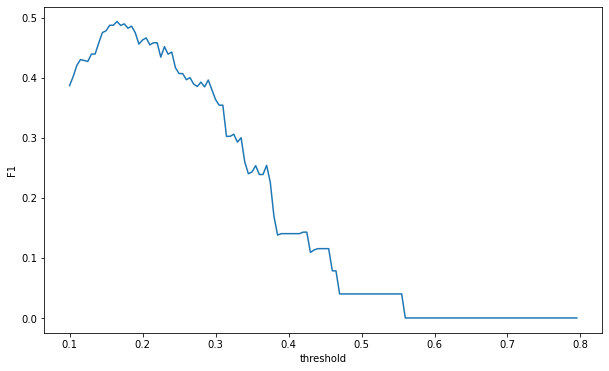

In [95]:
scores = []
thresholds = []
for t in np.arange(0.1, 0.8, 0.005):
    bin_pred = binarize(y_pred, t)
    f1 = metrics.f1_score(y_test, bin_pred)
    scores.append(f1)
    thresholds.append(t)

plt.figure(figsize=(10,6))
plt.ylabel("F1")
plt.xlabel("threshold")
plt.plot(thresholds, scores)
plt.savefig(path.join(DATA_DIR, 'images/model_42_threshold_dependence.png'))
plt.show()

Performances of each model (models, which predict nan, were skipped)  
41: F1=0.46; threshold=0.195  
42: F1=0.4935; threshold=0.165  
49: F1=0.4837; threshold=0.185   

# Short data + Over-sampling

In [265]:
sampler = RandomOverSampler(random_state=42)

X_train_os, y_train_os = sampler.fit_resample(X_train, y_train) 
print('Resampled dataset shape %s' % Counter(y_train_os)) 

X_test_os, y_test_os = sampler.fit_resample(X_test, y_test)
print('Resampled dataset shape %s' % Counter(y_test_os)) 

Resampled dataset shape Counter({0: 1057, 1: 1057})
Resampled dataset shape Counter({0: 190, 1: 190})


In [267]:
for i in range(50,60):
    model = Sequential()
    model.add(LSTM(128, activation="relu", input_shape=(max_length, 1), return_sequences=True,
                  kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))  
    model.add(LSTM(128, activation="relu", return_sequences=False,
                  kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer='adam', loss="binary_crossentropy")

    es = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
    model.fit(X_train_os, y_train_os, epochs=300, verbose=1, batch_size=128, validation_data=(X_test, y_test), callbacks=[es])

    try:
        model.save(path.join(DATA_DIR, f"models/LSTM5_{i}"))

        y_pred = model.predict(X_test)
    except:
        pass

Epoch 1/300
17/17 [==============================] - 16s 825ms/step - loss: 7.5465 - val_loss: 7.0321
Epoch 2/300
17/17 [==============================] - 14s 806ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 14s 808ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 14s 801ms/step - loss: nan - val_loss: nan
Epoch 5/300
17/17 [==============================] - 14s 806ms/step - loss: nan - val_loss: nan
Epoch 00005: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_50/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_50/assets


Epoch 1/300
17/17 [==============================] - 16s 823ms/step - loss: 6.8530 - val_loss: 5.7239
Epoch 2/300
17/17 [==============================] - 14s 804ms/step - loss: 5.1595 - val_loss: 4.4865
Epoch 3/300
17/17 [==============================] - 14s 806ms/step - loss: 4.1555 - val_loss: 3.6923
Epoch 4/300
17/17 [==============================] - 14s 805ms/step - loss: 3.5696 - val_loss: 3.2833
Epoch 5/300
17/17 [==============================] - 14s 807ms/step - loss: 3.2140 - val_loss: 3.0516
Epoch 6/300
17/17 [==============================] - 14s 799ms/step - loss: 2.9952 - val_loss: 2.8918
Epoch 7/300
17/17 [==============================] - 14s 806ms/step - loss: 2.8344 - val_loss: 2.6761
Epoch 8/300
17/17 [==============================] - 14s 804ms/step - loss: 2.7310 - val_loss: 2.5982
Epoch 9/300
17/17 [==============================] - 14s 803ms/step - loss: 2.6302 - val_loss: 2.4901
Epoch 10/300
17/17 [==============================] - 14s 806ms/step - loss: 2.542

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_51/assets


Epoch 1/300
17/17 [==============================] - 16s 827ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 14s 807ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 14s 802ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 14s 805ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_52/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_52/assets


Epoch 1/300
17/17 [==============================] - 16s 828ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 14s 806ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 14s 809ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 14s 812ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_53/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_53/assets


Epoch 1/300
17/17 [==============================] - 16s 828ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 14s 810ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 14s 807ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 14s 807ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_54/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_54/assets


Epoch 1/300
17/17 [==============================] - 16s 825ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 14s 805ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 14s 805ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 14s 808ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_55/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_55/assets


Epoch 1/300
17/17 [==============================] - 16s 829ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 14s 808ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 14s 808ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 14s 810ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_56/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_56/assets


Epoch 1/300
17/17 [==============================] - 16s 828ms/step - loss: 6.8614 - val_loss: 5.8301
Epoch 2/300
17/17 [==============================] - 14s 809ms/step - loss: 5.1740 - val_loss: 4.5126
Epoch 3/300
17/17 [==============================] - 14s 808ms/step - loss: 4.1614 - val_loss: 3.7176
Epoch 4/300
17/17 [==============================] - 14s 807ms/step - loss: 3.5714 - val_loss: 3.2488
Epoch 5/300
17/17 [==============================] - 14s 809ms/step - loss: 3.2167 - val_loss: 2.9637
Epoch 6/300
17/17 [==============================] - 14s 805ms/step - loss: 2.9990 - val_loss: 2.9209
Epoch 7/300
17/17 [==============================] - 14s 808ms/step - loss: 2.8444 - val_loss: 2.8066
Epoch 8/300
17/17 [==============================] - 14s 807ms/step - loss: 2.7246 - val_loss: 2.4988
Epoch 9/300
17/17 [==============================] - 14s 812ms/step - loss: 1117.8434 - val_loss: 2.6255
Epoch 10/300
17/17 [==============================] - 14s 810ms/step - loss: 2.

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_57/assets


Epoch 1/300
17/17 [==============================] - 16s 824ms/step - loss: 6.8417 - val_loss: 5.7822
Epoch 2/300
17/17 [==============================] - 14s 806ms/step - loss: 5.1152 - val_loss: 4.3645
Epoch 3/300
17/17 [==============================] - 14s 809ms/step - loss: 4.1020 - val_loss: 3.7612
Epoch 4/300
17/17 [==============================] - 14s 821ms/step - loss: 3.5254 - val_loss: 3.3531
Epoch 5/300
17/17 [==============================] - 14s 809ms/step - loss: 3.1848 - val_loss: 3.0595
Epoch 6/300
17/17 [==============================] - 14s 814ms/step - loss: 2.9647 - val_loss: 2.7939
Epoch 7/300
17/17 [==============================] - 14s 810ms/step - loss: 2.8187 - val_loss: 2.6978
Epoch 8/300
17/17 [==============================] - 14s 808ms/step - loss: 2.7050 - val_loss: 2.5454
Epoch 9/300
17/17 [==============================] - 14s 805ms/step - loss: 2.6141 - val_loss: 2.5176
Epoch 10/300
17/17 [==============================] - 14s 808ms/step - loss: 2.531

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_58/assets


Epoch 1/300
17/17 [==============================] - 16s 824ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 14s 804ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 14s 808ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 14s 806ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_59/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_59/assets


51: F1=0.466; threshold=0.41  
57: F1=0.47; threshold=0.495  
58: F1=0.504; threshold=0.505

### Smaller model

In [300]:
for i in range(60, 70):
    model = Sequential()
    model.add(LSTM(100, activation="relu", input_shape=(max_length, 1), return_sequences=True,
                  kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))  
    model.add(LSTM(100, activation="relu", return_sequences=False,
                  kernel_regularizer="l2", recurrent_regularizer="l2", bias_regularizer="l2"))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer='adam', loss="binary_crossentropy")

    es = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
    model.fit(X_train_os, y_train_os, epochs=300, verbose=1, batch_size=128, validation_data=(X_test[:120], y_test[:120]), callbacks=[es])

    try:
        model.save(path.join(DATA_DIR, f"models/LSTM5_{i}"))

    except:
        pass

Epoch 1/300
17/17 [==============================] - 12s 594ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 10s 572ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 10s 572ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 10s 572ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_60/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_60/assets


Epoch 1/300
17/17 [==============================] - 12s 596ms/step - loss: 5.5744 - val_loss: 4.7704
Epoch 2/300
17/17 [==============================] - 10s 579ms/step - loss: 4.3309 - val_loss: 3.7689
Epoch 3/300
17/17 [==============================] - 10s 580ms/step - loss: 3.5594 - val_loss: 3.2043
Epoch 4/300
17/17 [==============================] - 10s 581ms/step - loss: 3.0753 - val_loss: 2.8296
Epoch 5/300
17/17 [==============================] - 10s 581ms/step - loss: 2.7649 - val_loss: 2.6141
Epoch 6/300
17/17 [==============================] - 10s 578ms/step - loss: 2.5601 - val_loss: 2.3938
Epoch 7/300
17/17 [==============================] - 10s 580ms/step - loss: 2.4146 - val_loss: 2.2926
Epoch 8/300
17/17 [==============================] - 10s 578ms/step - loss: 2.3133 - val_loss: 2.2320
Epoch 9/300
17/17 [==============================] - 10s 583ms/step - loss: 2.2230 - val_loss: 2.1952
Epoch 10/300
17/17 [==============================] - 10s 580ms/step - loss: 2.146

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_61/assets


Epoch 1/300
17/17 [==============================] - 12s 606ms/step - loss: 49.3877 - val_loss: 5.6467
Epoch 2/300
17/17 [==============================] - 10s 585ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 10s 585ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 10s 580ms/step - loss: nan - val_loss: nan
Epoch 5/300
17/17 [==============================] - 10s 583ms/step - loss: nan - val_loss: nan
Epoch 00005: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_62/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_62/assets


Epoch 1/300
17/17 [==============================] - 12s 601ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 10s 584ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 10s 588ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 10s 587ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_63/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_63/assets


Epoch 1/300
17/17 [==============================] - 13s 653ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 10s 592ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 10s 603ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 10s 589ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_64/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_64/assets


Epoch 1/300
17/17 [==============================] - 12s 597ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 10s 594ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 10s 590ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 10s 588ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_65/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_65/assets


Epoch 1/300
17/17 [==============================] - 12s 600ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 10s 594ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 10s 588ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 10s 586ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_66/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_66/assets


Epoch 1/300
17/17 [==============================] - 12s 611ms/step - loss: 5.6279 - val_loss: 4.8405
Epoch 2/300
17/17 [==============================] - 10s 580ms/step - loss: 4.3919 - val_loss: 3.8892
Epoch 3/300
17/17 [==============================] - 10s 581ms/step - loss: 3.6045 - val_loss: 3.3333
Epoch 4/300
17/17 [==============================] - 10s 578ms/step - loss: 3.1126 - val_loss: 2.8362
Epoch 5/300
17/17 [==============================] - 10s 590ms/step - loss: 2.7975 - val_loss: 2.6240
Epoch 6/300
17/17 [==============================] - 10s 579ms/step - loss: 2.5944 - val_loss: 2.5505
Epoch 7/300
17/17 [==============================] - 10s 585ms/step - loss: 2.4556 - val_loss: 2.4119
Epoch 8/300
17/17 [==============================] - 10s 585ms/step - loss: 2.3456 - val_loss: 2.2906
Epoch 9/300
17/17 [==============================] - 10s 584ms/step - loss: 2.2543 - val_loss: 2.1134
Epoch 10/300
17/17 [==============================] - 10s 587ms/step - loss: 2.175

INFO:tensorflow:Assets written to: ../../data/models/LSTM5_67/assets


Epoch 1/300
17/17 [==============================] - 12s 611ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 10s 586ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 10s 600ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 10s 589ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_68/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_68/assets


Epoch 1/300
17/17 [==============================] - 13s 607ms/step - loss: nan - val_loss: nan
Epoch 2/300
17/17 [==============================] - 10s 576ms/step - loss: nan - val_loss: nan
Epoch 3/300
17/17 [==============================] - 10s 590ms/step - loss: nan - val_loss: nan
Epoch 4/300
17/17 [==============================] - 10s 596ms/step - loss: nan - val_loss: nan
Epoch 00004: early stopping
INFO:tensorflow:Assets written to: ../../data/models/LSTM5_69/assets


INFO:tensorflow:Assets written to: ../../data/models/LSTM5_69/assets
